# **Combine and load Data**

Using device: cuda

Dataset Root Paths:
1: /content/OpenRL deepfake
2: /content/fake-and-real-images
3: /content/unzip-Whab-deepfake

--- Loading and Combining Datasets ---

Loading Train datasets...
  Loaded 42000 images from /content/OpenRL deepfake/Train (Classes: ['Fake', 'Real'])
  Loaded 14000 images from /content/fake-and-real-images/Train (Classes: ['Fake', 'Real'])
  Loaded 14000 images from /content/unzip-Whab-deepfake/Train (Classes: ['Fake', 'Real'])
Combined Train dataset: 70000 total images.

Loading Validation datasets...
  Loaded 12000 images from /content/OpenRL deepfake/Validation (Classes: ['Fake', 'Real'])
  Loaded  4000 images from /content/fake-and-real-images/Validation (Classes: ['Fake', 'Real'])
  Loaded  4000 images from /content/unzip-Whab-deepfake/Validation (Classes: ['Fake', 'Real'])
Combined Validation dataset: 20000 total images.

Loading Test datasets...
  Loaded  6000 images from /content/OpenRL deepfake/Test (Classes: ['Fake', 'Real'])
  Loaded  2000 

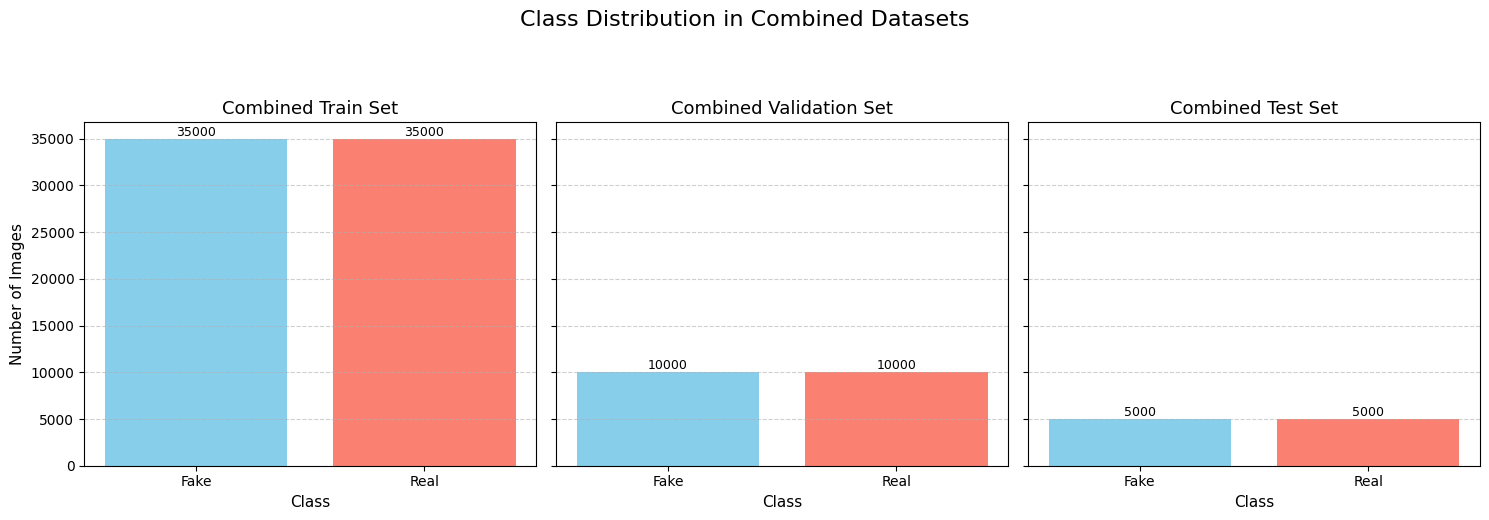

In [ ]:
import torch
import os
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets
import torchvision.transforms as TF
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

dataset1_path = '/content/OpenRL deepfake'
dataset2_path = '/content/fake-and-real-images'
dataset3_path = '/content/unzip-Whab-deepfake'

print("\nDataset Root Paths:")
print(f"1: {dataset1_path}")
print(f"2: {dataset2_path}")
print(f'3: {dataset3_path}')

train_tran = TF.Compose([
    TF.Resize((224, 224)),
    TF.RandomHorizontalFlip(p=0.5),
    TF.RandomRotation(degrees=2),
    TF.RandomApply([TF.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.3),
    TF.RandomApply([TF.ColorJitter(brightness=0.1, contrast=0.05)], p=0.3),
    TF.ToTensor(),
    TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_tran = TF.Compose([
    TF.Resize((224, 224)),
    TF.ToTensor(),
    TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_dataset_split(dataset_root, split_name, transform_to_apply):
    path = os.path.join(dataset_root, split_name)
    if not os.path.isdir(path):
        print(f"  Skipping: Path not found or not a directory - {path}")
        return None
    try:
        dataset = datasets.ImageFolder(path, transform=transform_to_apply)
        if len(dataset) == 0:
            print(f"  Skipping: No images found in - {path}")
            return None
        print(f"  Loaded {len(dataset):>5} images from {path} (Classes: {dataset.classes})")
        return dataset
    except Exception as e:
        print(f"  Skipping: Error loading {path} - {e}")
        return None

print("\n--- Loading and Combining Datasets ---")
dataset_paths = [dataset1_path, dataset2_path,dataset3_path]
combined_splits = {}

for split in ['Train', 'Validation', 'Test']:
    print(f"\nLoading {split} datasets...")
    current_transform = train_tran if split == 'Train' else val_tran
    loaded_datasets = [load_dataset_split(dp, split, current_transform) for dp in dataset_paths]

    valid_datasets = [ds for ds in loaded_datasets if ds is not None]

    if valid_datasets:
        combined_splits[split] = ConcatDataset(valid_datasets)
        print(f"Combined {split} dataset: {len(combined_splits[split])} total images.")
    else:
        combined_splits[split] = None
        print(f"No {split} datasets were loaded successfully.")

print(f"\n--- Final Dataset Summary ---")
for split_name, dataset_obj in combined_splits.items():
    if dataset_obj:
        print(f"Total {split_name} images: {len(dataset_obj)}")
    else:
        print(f"Total {split_name} images: 0 (or not loaded)")

print(f"\n--- Class Balance Analysis (Single Figure Output) ---")

def get_class_distribution_for_plotting(concat_dataset, dataset_name_title):

    if concat_dataset is None or not hasattr(concat_dataset, 'datasets'):
        print(f"Cannot analyze {dataset_name_title}: Dataset is not loaded or invalid.")
        return None, None

    all_targets = []
    class_to_idx = None
    for ds_component in concat_dataset.datasets:
        if ds_component and hasattr(ds_component, 'class_to_idx'):
            class_to_idx = ds_component.class_to_idx
            break

    if class_to_idx is None:
        print(f"Warning: Could not determine class-to-index mapping for {dataset_name_title}.")
        raw_targets = []
        for ds_component in concat_dataset.datasets:
            if ds_component and hasattr(ds_component, 'targets'):
                raw_targets.extend(ds_component.targets)
        if not raw_targets:
            print(f"No image labels found in {dataset_name_title}.")
            return None, None
        class_name_counts = Counter(raw_targets)
        return class_name_counts, {idx: f"Label_{idx}" for idx in class_name_counts.keys()}

    idx_to_class = {v: k for k, v in class_to_idx.items()}
    for ds_component in concat_dataset.datasets:
        if ds_component and hasattr(ds_component, 'targets'):
            all_targets.extend(ds_component.targets)

    if not all_targets:
        print(f"No image labels found in {dataset_name_title}.")
        return None, class_to_idx

    target_counts = Counter(all_targets)
    class_name_counts = {idx_to_class.get(idx, f"UnknownIdx_{idx}"): count
                         for idx, count in target_counts.items()}

    print(f"\nDistribution for {dataset_name_title}:")
    if class_to_idx and not all(isinstance(k, str) for k in class_name_counts.keys()):
         print(f"  Class Mapping used: {class_to_idx}")
    print(f"  Counts: {class_name_counts}")
    return class_name_counts, class_to_idx


datasets_to_plot_info = {}
class_map_for_legend = None

for split_name, dataset_obj in combined_splits.items():
    if dataset_obj:
        counts, class_map = get_class_distribution_for_plotting(dataset_obj, f"Combined {split_name} Set")
        if counts:
            datasets_to_plot_info[f"Combined {split_name} Set"] = counts
            if class_map_for_legend is None and class_map:
                class_map_for_legend = class_map
    else:
        print(f"\nSkipping class balance for {split_name} set as it was not loaded.")

if datasets_to_plot_info:
    num_subplots = len(datasets_to_plot_info)
    fig, axes = plt.subplots(1, num_subplots, figsize=(5 * num_subplots, 5), sharey=True)
    if num_subplots == 1:
        axes = [axes]
    fig.suptitle('Class Distribution in Combined Datasets', fontsize=16, y=1.03)

    bar_colors = ['skyblue', 'salmon']

    for i, (plot_title, data_counts) in enumerate(datasets_to_plot_info.items()):
        ax = axes[i]

        if class_map_for_legend and not all(isinstance(k, str) for k in data_counts.keys()):
            idx_to_class_legend = {v:k for k,v in class_map_for_legend.items()}
            labels_for_plot = sorted(idx_to_class_legend.values(), key=lambda x: class_map_for_legend.get(x, -1))
            values_for_plot = [data_counts.get(class_map_for_legend.get(name, -1), 0) for name in labels_for_plot]
        elif class_map_for_legend and all(isinstance(k, str) for k in data_counts.keys()):
            sorted_labels_from_map = sorted(class_map_for_legend.keys(), key=lambda x: class_map_for_legend.get(x, -1))
            labels_for_plot = [lbl for lbl in sorted_labels_from_map if lbl in data_counts]
            values_for_plot = [data_counts.get(lbl,0) for lbl in labels_for_plot]

        else:
            labels_for_plot = sorted(list(data_counts.keys()))
            values_for_plot = [data_counts[lbl] for lbl in labels_for_plot]


        bars = ax.bar(labels_for_plot, values_for_plot, color=bar_colors[:len(labels_for_plot)])
        ax.set_title(plot_title, fontsize=13)
        ax.set_xlabel("Class", fontsize=11)
        if i == 0:
            ax.set_ylabel("Number of Images", fontsize=11)

        for bar in bars:
            y_val = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.0, y_val, int(y_val),
                    va='bottom', ha='center', fontsize=9)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.set_ylim(bottom=0)
        ax.tick_params(axis='x')


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("No data available to plot distributions.")

# **A100 Stand-out Model (ResNet50 Model)**

## **Step 1**

In [ ]:
#A100
train_loader = DataLoader(combined_splits['Train'],batch_size = 512, shuffle = True,pin_memory= True,num_workers=8,prefetch_factor=2,persistent_workers=True)#, pin_memory=True, persistent_workers= True
val_loader = DataLoader(combined_splits['Validation'],batch_size = 512, shuffle = False,pin_memory= False)#, pin_memory=True,persistent_workers= True
test_loader = DataLoader(combined_splits['Test'], batch_size = 512, shuffle = False,pin_memory= False)#, pin_memory=True, persistent_workers= True

In [ ]:
print(f'Train data set size: {len(combined_splits["Train"])}')
print(f'Validation data set size: {len(combined_splits["Validation"])}')
print(f'Test data set size: {len(combined_splits["Test"])}')

Train data set size: 70000
Validation data set size: 20000
Test data set size: 10000


In [ ]:
total_dataset_size = len(combined_splits["Train"]) + len(combined_splits["Validation"]) + len(combined_splits["Test"])

print(f'\nTotal dataset size: {total_dataset_size}')

train_percentage = (len(combined_splits["Train"]) / total_dataset_size) * 100
val_percentage = (len(combined_splits["Validation"]) / total_dataset_size) * 100
test_percentage = (len(combined_splits["Test"]) / total_dataset_size) * 100

print(f'Train data set percentage: {train_percentage:.2f}%')
print(f'Validation data set percentage: {val_percentage:.2f}%')
print(f'Test data set percentage: {test_percentage:.2f}%')


Total dataset size: 100000
Train data set percentage: 70.00%
Validation data set percentage: 20.00%
Test data set percentage: 10.00%


In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 2.3.0 which is incompatible.
tensorflow 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.14.0 which is incompatible.
deepfake-detector 1.4 requires numpy==1.24.3, but you have numpy 2.3.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.13.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.13.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.13.0 which is incompatible.


In [ ]:
import torch
from torch.nn import CrossEntropyLoss
from torch import nn
from torch.utils.data import Dataset
from torchmetrics import Accuracy
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

from torchvision.transforms.functional import pil_to_tensor

from PIL import Image
import os

from tqdm.auto import tqdm
import torchvision.models as models
import torch.nn.functional as F


ImportError: cannot import name 'TypeIs' from 'typing_extensions' (/usr/local/lib/python3.11/dist-packages/typing_extensions.py)

In [ ]:
first_train_dataset = combined_splits['Train'].datasets[0]

In [ ]:
classes = first_train_dataset.classes
n_classes = len(classes)
classes

['Fake', 'Real']

In [ ]:
n_train = len(train_loader.dataset)
n_val = len(val_loader.dataset)

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4),
    nn.Linear(512, 2)
)

In [ ]:
for param in model.parameters():
  param.requires_grad = False

for param in model.fc.parameters():
  param.requires_grad = True

In [ ]:
gpu = torch.cuda.is_available()
print(gpu)

if gpu:
  model.cuda()

model.to(device)

True


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.fc.parameters(),lr = 2.6e-3)

In [ ]:
n_epochs = 15

best_val_loss = float('inf')
CHECKPOINT_DIR = '/content/drive/MyDrive/Deepfake_stand_out_model_bestcheck/ResNet50 CE 3Data/Stage1_balanced'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

for epoch in range(n_epochs):

    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} Training"):
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        pred = model(images)
        loss = cross_entropy(pred,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} Validation"):
            if gpu:
                images, labels = images.cuda(), labels.cuda()
            pred = model(images)
            loss = cross_entropy(pred,labels)
            val_loss += loss.item() * images.size(0)

    avg_train_loss = train_loss / n_train
    avg_val_loss = val_loss / n_val

    print(f"Epoch {epoch+1}/{n_epochs}: Training loss = {avg_train_loss:.4f}, Validation loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(f"Validation loss improved. Saving checkpoint for epoch {epoch+1} with loss {best_val_loss:.4f}")

        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'validation_loss': avg_val_loss,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'best_validation_loss': best_val_loss,
        }

        checkpoint_filename = f'Stage1_fix_ResNet50_CE_3Data_checkpoint_best_epoch_{epoch+1}.pth'
        CHECKPOINT_SAVE_PATH = os.path.join(CHECKPOINT_DIR, checkpoint_filename)
        torch.save(checkpoint, CHECKPOINT_SAVE_PATH)
    else:
        print(f"Validation loss did not improve from {best_val_loss:.4f}.")


Epoch 1/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 1/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/15: Training loss = 0.6372, Validation loss = 0.5914
Validation loss improved. Saving checkpoint for epoch 1 with loss 0.5914


Epoch 2/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/15: Training loss = 0.5930, Validation loss = 0.5759
Validation loss improved. Saving checkpoint for epoch 2 with loss 0.5759


Epoch 3/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/15: Training loss = 0.5842, Validation loss = 0.5726
Validation loss improved. Saving checkpoint for epoch 3 with loss 0.5726


Epoch 4/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/15: Training loss = 0.5731, Validation loss = 0.5714
Validation loss improved. Saving checkpoint for epoch 4 with loss 0.5714


Epoch 5/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/15: Training loss = 0.5630, Validation loss = 0.5710
Validation loss improved. Saving checkpoint for epoch 5 with loss 0.5710


Epoch 6/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/15: Training loss = 0.5547, Validation loss = 0.5690
Validation loss improved. Saving checkpoint for epoch 6 with loss 0.5690


Epoch 7/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/15: Training loss = 0.5438, Validation loss = 0.5935
Validation loss did not improve from 0.5690.


Epoch 8/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/15: Training loss = 0.5357, Validation loss = 0.5660
Validation loss improved. Saving checkpoint for epoch 8 with loss 0.5660


Epoch 9/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/15: Training loss = 0.5279, Validation loss = 0.5752
Validation loss did not improve from 0.5660.


Epoch 10/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/15: Training loss = 0.5177, Validation loss = 0.5778
Validation loss did not improve from 0.5660.


Epoch 11/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/15: Training loss = 0.5071, Validation loss = 0.5830
Validation loss did not improve from 0.5660.


Epoch 12/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/15: Training loss = 0.4965, Validation loss = 0.5906
Validation loss did not improve from 0.5660.


Epoch 13/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/15: Training loss = 0.4877, Validation loss = 0.5934
Validation loss did not improve from 0.5660.


Epoch 14/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/15: Training loss = 0.4779, Validation loss = 0.6054
Validation loss did not improve from 0.5660.


Epoch 15/15 Training:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 15/15 Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/15: Training loss = 0.4653, Validation loss = 0.6109
Validation loss did not improve from 0.5660.


In [ ]:
y_pred, y_true = [], []
model.eval()
for images, labels in tqdm(val_loader):
    images, labels = images.to(device), labels.to(device)
    pred = model(images)
    yp = pred.argmax(dim=1).tolist()
    yt = labels.tolist()
    y_pred.extend(yp)
    y_true.extend(yt)

print("Validation ResNet50_CE_3D_epoch 15 balance:")
print(classification_report(y_true, y_pred))

  0%|          | 0/40 [00:00<?, ?it/s]

Validation ResNet50_CE_3D_epoch 15 balance:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65     10000
           1       0.65      0.63      0.64     10000

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



In [ ]:
y_test_pred, y_test_true = [], []
model.eval()

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        pred = model(images)
        yp = pred.argmax(dim=1).tolist()
        yt = labels.tolist()
        y_test_pred.extend(yp)
        y_test_true.extend(yt)

print("Test ResNet50_CE_3D_epoch 15 balance:")
print(classification_report(y_test_true, y_test_pred))

  0%|          | 0/20 [00:00<?, ?it/s]

Test ResNet50_CE_3D_epoch 15 balance:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      5000
           1       0.64      0.63      0.64      5000

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.64      0.64      0.64     10000



In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          percentify_numbers = True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    if percentify_numbers:
        cm = (100 * cm / cm.sum()).round().astype(int)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

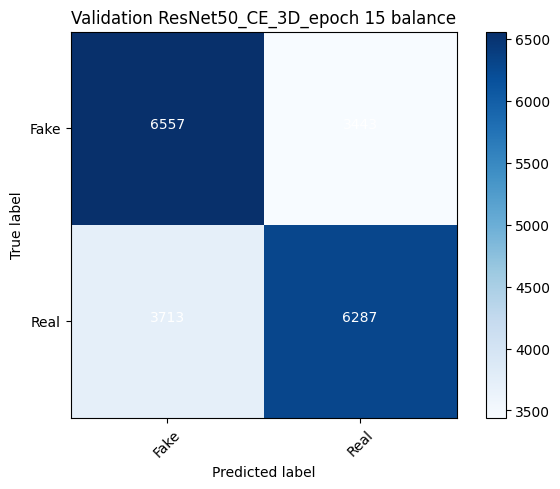

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
classes = ['Fake', 'Real']
plot_confusion_matrix(cm,
                      classes=classes,
                      percentify_numbers = False,
                      title="Validation ResNet50_CE_3D_epoch 15 balance")

plt.show()

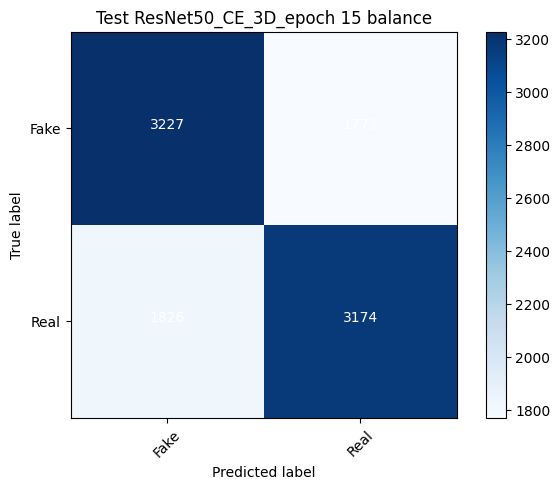

In [ ]:
cm = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred)
classes = ['Fake', 'Real']
plot_confusion_matrix(cm,
                      classes=classes,
                      percentify_numbers = False,
                      title="Test ResNet50_CE_3D_epoch 15 balance")

plt.show()

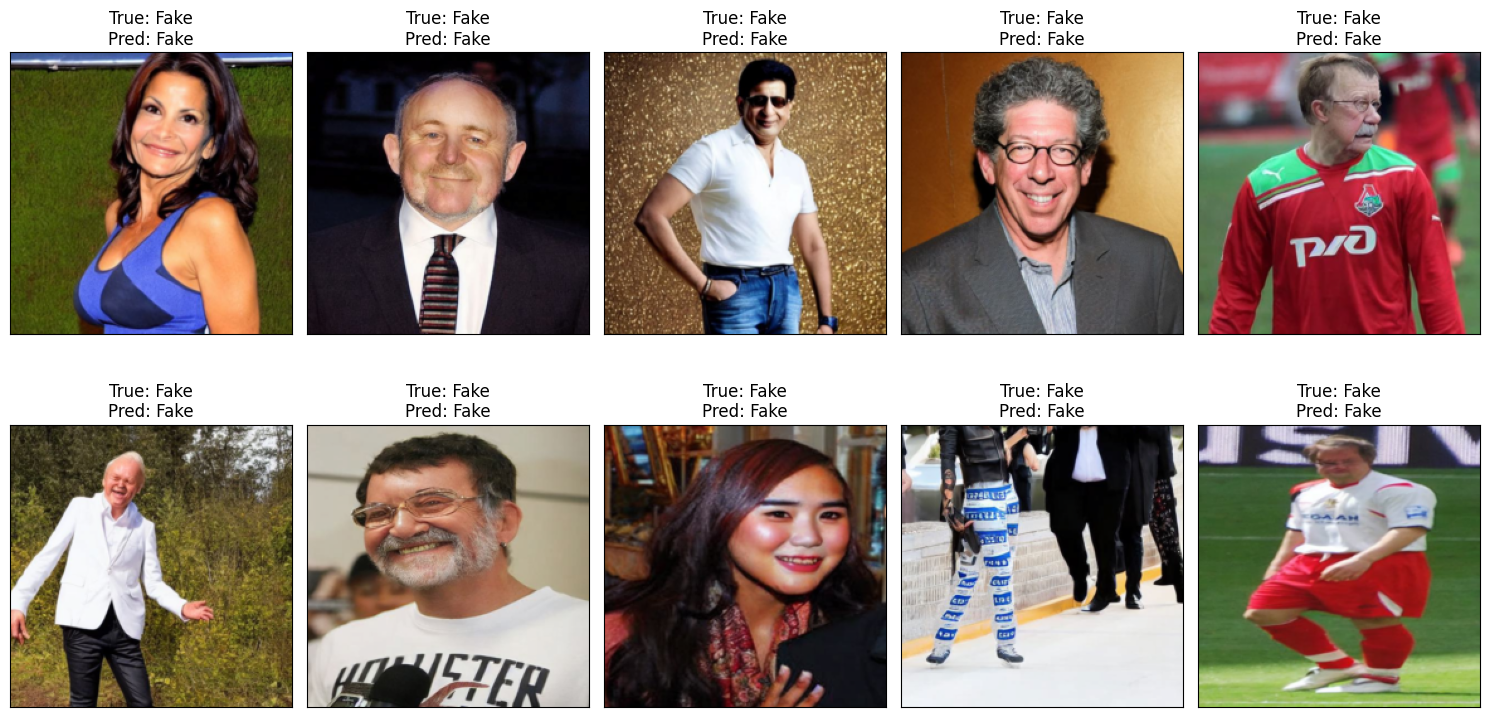

In [ ]:
images, labels = next(iter(test_loader))

model.eval()

batch_size = test_loader.batch_size
with torch.no_grad():
    images = images.to(device)
    outputs = model(images)

_, predicted_indices = torch.max(outputs.data, 1)

first_train_dataset = combined_splits['Train'].datasets[0]
idx_to_class_name = {v: k for k, v in first_train_dataset.class_to_idx.items()}

fig = plt.figure(figsize=(15, 8))
num_images_to_show = 10

image_indices = list(range(batch_size))
np.random.shuffle(image_indices)


for i in range(min(num_images_to_show, batch_size)):
    current_image_index = image_indices[i]
    image = images[current_image_index].cpu().squeeze(0).numpy()
    true_label_name = idx_to_class_name[labels[current_image_index].item()]
    predicted_label_name = idx_to_class_name[predicted_indices[current_image_index].item()]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_to_display = np.transpose(image, (1, 2, 0))
    image_to_display = std * image_to_display + mean
    image_to_display = np.clip(image_to_display, 0, 1)

    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(image_to_display)
    ax.set_title(f"True: {true_label_name}\nPred: {predicted_label_name}")

plt.tight_layout()
plt.show()

## **Step 2**

In [ ]:
#A100
train_loader = DataLoader(combined_splits['Train'],batch_size = 1024, shuffle = True,pin_memory= True,num_workers=8,prefetch_factor=2,persistent_workers=True)#, pin_memory=True, persistent_workers= True
val_loader = DataLoader(combined_splits['Validation'],batch_size = 256, shuffle = False,pin_memory= True)#, pin_memory=True,persistent_workers= True
test_loader = DataLoader(combined_splits['Test'], batch_size = 256, shuffle = False,pin_memory= True)#, pin_memory=True, persistent_workers= True

In [ ]:
print(f'Train data set size: {len(combined_splits["Train"])}')
print(f'Validation data set size: {len(combined_splits["Validation"])}')
print(f'Test data set size: {len(combined_splits["Test"])}')

Train data set size: 70000
Validation data set size: 20000
Test data set size: 10000


In [ ]:
total_dataset_size = len(combined_splits["Train"]) + len(combined_splits["Validation"]) + len(combined_splits["Test"])

print(f'\nTotal dataset size: {total_dataset_size}')

train_percentage = (len(combined_splits["Train"]) / total_dataset_size) * 100
val_percentage = (len(combined_splits["Validation"]) / total_dataset_size) * 100
test_percentage = (len(combined_splits["Test"]) / total_dataset_size) * 100

print(f'Train data set percentage: {train_percentage:.2f}%')
print(f'Validation data set percentage: {val_percentage:.2f}%')
print(f'Test data set percentage: {test_percentage:.2f}%')


Total dataset size: 100000
Train data set percentage: 70.00%
Validation data set percentage: 20.00%
Test data set percentage: 10.00%


In [ ]:
!pip install -q torchmetrics

In [ ]:
import torch
from torch.nn import CrossEntropyLoss
from torch import nn
from torch.utils.data import Dataset
from torchmetrics import Accuracy
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

from torchvision.transforms.functional import pil_to_tensor

from PIL import Image
import os

from tqdm.auto import tqdm
import torchvision.models as models
import torch.nn.functional as F


In [ ]:
first_train_dataset = combined_splits['Train'].datasets[0]

In [ ]:
classes = first_train_dataset.classes
n_classes = len(classes)
classes

['Fake', 'Real']

In [ ]:
n_train = len(train_loader.dataset)
n_val = len(val_loader.dataset)

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(512, 2)
)

In [ ]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.fc.parameters(),lr = 2e-2)

In [ ]:
for param in model.parameters():
  param.requires_grad = False

for param in model.layer3.parameters():
  param.requires_grad = True

for param in model.layer4.parameters():
  param.requires_grad = True

for param in model.fc.parameters():
  param.requires_grad = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
n_epochs = 10

best_val_loss = float('inf')
CHECKPOINT_DIR = '/content/drive/MyDrive/Deepfake_stand_out_model_bestcheck/ResNet50 CE 3Data/Stage2_balanced'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

for epoch in range(n_epochs):

    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} Training"):

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        pred = model(images)
        loss = cross_entropy(pred, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} Validation"):

            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = cross_entropy(pred, labels)
            val_loss += loss.item() * images.size(0)

    avg_train_loss = train_loss / n_train
    avg_val_loss = val_loss / n_val

    print(f"Epoch {epoch+1}/{n_epochs}: Training loss = {avg_train_loss:.4f}, Validation loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(f"Validation loss improved. Saving checkpoint for epoch {epoch+1} with loss {best_val_loss:.4f}")

        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'validation_loss': avg_val_loss,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'best_validation_loss': best_val_loss,
        }

        checkpoint_filename = f'Stage2_fix_ResNet50_CE_3Data_checkpoint_best_epoch_{epoch+1}.pth'
        CHECKPOINT_SAVE_PATH = os.path.join(CHECKPOINT_DIR, checkpoint_filename)
        torch.save(checkpoint, CHECKPOINT_SAVE_PATH)
    else:
        print(f"Validation loss did not improve from {best_val_loss:.4f}.")


Epoch 1/10 Training:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 1/10 Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/10: Training loss = 0.7541, Validation loss = 0.7313
Validation loss improved. Saving checkpoint for epoch 1 with loss 0.7313


Epoch 2/10 Training:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2/10 Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/10: Training loss = 0.7533, Validation loss = 0.7325
Validation loss did not improve from 0.7313.


Epoch 3/10 Training:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3/10 Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/10: Training loss = 0.7528, Validation loss = 0.7329
Validation loss did not improve from 0.7313.


Epoch 4/10 Training:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 4/10 Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/10: Training loss = 0.7525, Validation loss = 0.7323
Validation loss did not improve from 0.7313.


Epoch 5/10 Training:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 5/10 Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/10: Training loss = 0.7548, Validation loss = 0.7328
Validation loss did not improve from 0.7313.


Epoch 6/10 Training:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 6/10 Validation:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(512, 2)
)

for param in model.parameters():
  param.requires_grad = False

for param in model.layer3.parameters():
  param.requires_grad = True

for param in model.layer4.parameters():
  param.requires_grad = True

for param in model.fc.parameters():
  param.requires_grad = True

checkpoint_path = '/content/drive/MyDrive/Deepfake_stand_out_model_bestcheck/ResNet50 CE 3Data/Stage2_balanced/Stage2_fix_ResNet50_CE_3Data_checkpoint_best_epoch_1.pth'

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
y_pred, y_true = [], []
model.eval()
for images, labels in tqdm(val_loader):
    images, labels = images.to(device), labels.to(device)
    pred = model(images)
    yp = pred.argmax(dim=1).tolist()
    yt = labels.tolist()
    y_pred.extend(yp)
    y_true.extend(yt)

print("Validation ResNet50_CE_3D_Stage2 epoch 1 balance:")
print(classification_report(y_true, y_pred))

  0%|          | 0/79 [00:00<?, ?it/s]

Validation ResNet50_CE_3D_Stage2 epoch 1 balance:
              precision    recall  f1-score   support

           0       0.51      0.20      0.29     10000
           1       0.50      0.81      0.62     10000

    accuracy                           0.50     20000
   macro avg       0.51      0.50      0.45     20000
weighted avg       0.51      0.50      0.45     20000



In [ ]:
y_test_pred, y_test_true = [], []
model.eval()

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        pred = model(images)
        yp = pred.argmax(dim=1).tolist()
        yt = labels.tolist()
        y_test_pred.extend(yp)
        y_test_true.extend(yt)

print("Test ResNet50_CE_3D_Stage2 epoch 1 balance:")
print(classification_report(y_test_true, y_test_pred))

  0%|          | 0/40 [00:00<?, ?it/s]

Test ResNet50_CE_3D_Stage2 epoch 1 balance:
              precision    recall  f1-score   support

           0       0.50      0.19      0.28      5000
           1       0.50      0.81      0.62      5000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.45     10000
weighted avg       0.50      0.50      0.45     10000



In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          percentify_numbers = True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    if percentify_numbers:
        cm = (100 * cm / cm.sum()).round().astype(int)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

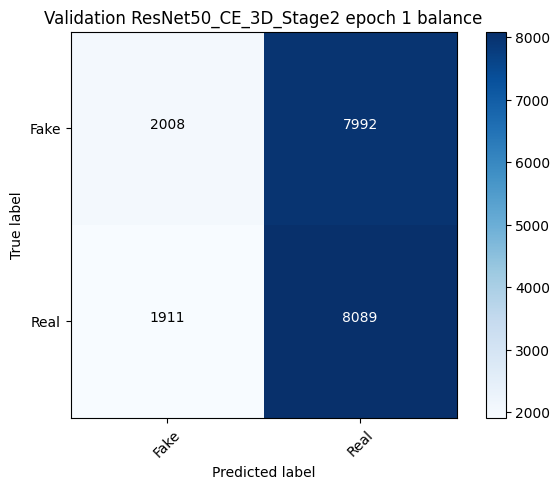

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
classes = ['Fake', 'Real']
plot_confusion_matrix(cm,
                      classes=classes,
                      percentify_numbers = False,
                      title="Validation ResNet50_CE_3D_Stage2 epoch 1 balance")

plt.show()

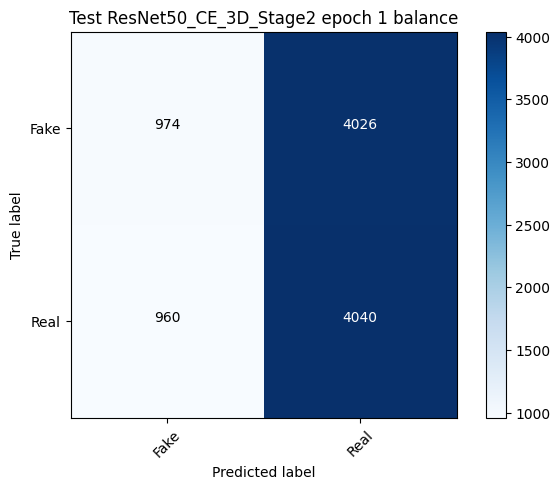

In [ ]:
cm = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred)
classes = ['Fake', 'Real']
plot_confusion_matrix(cm,
                      classes=classes,
                      percentify_numbers = False,
                      title="Test ResNet50_CE_3D_Stage2 epoch 1 balance")

plt.show()

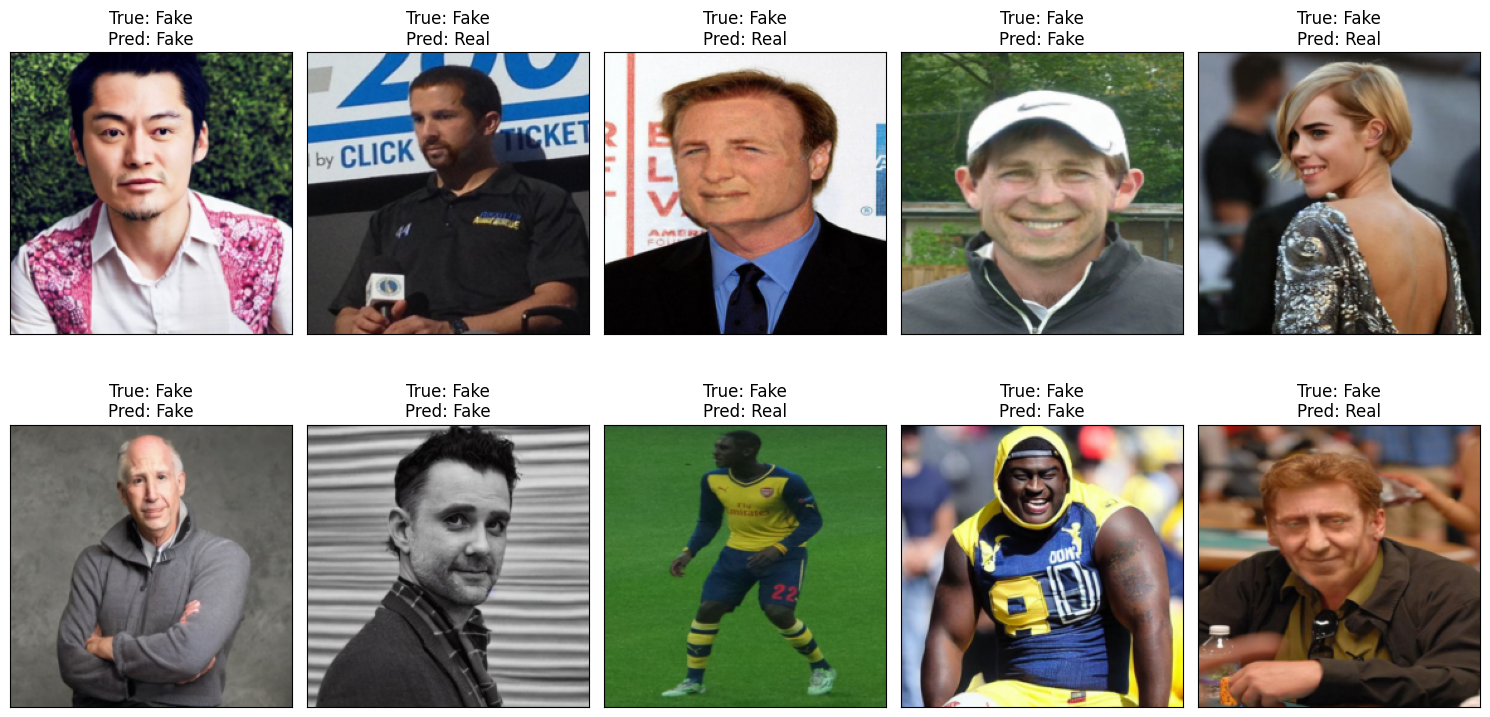

In [ ]:
images, labels = next(iter(test_loader))

model.eval()

batch_size = test_loader.batch_size
with torch.no_grad():
    images = images.to(device)
    outputs = model(images)

_, predicted_indices = torch.max(outputs.data, 1)

first_train_dataset = combined_splits['Train'].datasets[0]
idx_to_class_name = {v: k for k, v in first_train_dataset.class_to_idx.items()}

fig = plt.figure(figsize=(15, 8))
num_images_to_show = 10

image_indices = list(range(batch_size))
np.random.shuffle(image_indices)


for i in range(min(num_images_to_show, batch_size)):
    current_image_index = image_indices[i]
    image = images[current_image_index].cpu().squeeze(0).numpy()
    true_label_name = idx_to_class_name[labels[current_image_index].item()]
    predicted_label_name = idx_to_class_name[predicted_indices[current_image_index].item()]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_to_display = np.transpose(image, (1, 2, 0))
    image_to_display = std * image_to_display + mean
    image_to_display = np.clip(image_to_display, 0, 1)

    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(image_to_display)
    ax.set_title(f"True: {true_label_name}\nPred: {predicted_label_name}")

plt.tight_layout()
plt.show()